# DREAM EXPERIMENT: analysis of simulated events

Importing modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optim
import scipy.stats as stats

# filename (to read data)
fileName = '_35p_degrees.txt'
directory = '../datasets/'
fileName = directory + fileName

# constants of the run
number_generated_events = 500000
number_detected_events = 68

## Rate of detected events

I can convert the number of generated events into time in lab through the following formula:
$$ T[s] = \frac{N_g}{0.019\cdot S[cm^2]} $$
where $N_g$ is the number of generated events and $S$ is the surface of the tangent plane. In pur case the tangent plane is a circle of radius $r = \frac{1}{2}R$, with $R$ radius of the envelope.
Then, since the rate is the number of detected events $N_d$ per time, we recover:
$$ \Gamma[s^{-1}] = \frac{N_d \cdot 0.019\cdot S[cm^2]}{N_g} $$

In [2]:
# from theory:
expected_flux = 1 #muon/cm^2/min
expected_flux = expected_flux/60 #muon/cm^2/s
surface_effective = 1*2.2 #cm^2
expected_rate = expected_flux*surface_effective
print('THEORY:\nThe expect rate of detection is: {:e} Hz\n'.format(expected_rate))

# rate in lab
true_time_lab = 92*3600 # 92h
rate_lab = 443/true_time_lab
print('LABORATORY:\nRate of detected muons in lab is: {:e} Hz\n'.format(rate_lab))

# my data
Ng = number_generated_events
Nd = number_detected_events
delta_Nd = np.sqrt(Nd)
radius_envelope = 19.2389 #cm
surface = 4*(radius_envelope)*(radius_envelope) #cm^2

# extrapolate quantities
time_lab = Ng/0.019/surface
rate = Nd*0.019*surface/Ng
delta_rate = delta_Nd*0.019*surface/Ng

# rate of detected events
print('SIMULATION:\nRate in simulation: {:e} Hz +/- {:e}'.format(rate, delta_rate))
print('with corresponding time in lab: {:e} s'.format(time_lab) + 'that is {:e} hours'.format(time_lab/3600) + '\n(assuming hypotetical poissonian fluctuations on number of detected events)')

THEORY:
The expect rate of detection is: 3.666667e-02 Hz

LABORATORY:
Rate of detected muons in lab is: 1.337560e-03 Hz

SIMULATION:
Rate in simulation: 3.825718e-03 Hz +/- 4.639365e-04
with corresponding time in lab: 1.777444e+04 sthat is 4.937345e+00 hours
(assuming hypotetical poissonian fluctuations on number of detected events)


## Energy losses in detectors: a first check

Loading data from `energies.txt`:

In [3]:
# loading data from simulation
energyBGO, energyScint1, energyScint2 = np.loadtxt(fileName, unpack=True, usecols=(1,2,3))
energies = [energyBGO, energyScint1, energyScint2]

# remove energies = 0 and energies > 200 MeV from datasets
for set in energies:
    for value in set:
        if value==0 or value>0:
            set = np.setdiff1d(set, np.array([value]))

[energyBGO, energyScint1, energyScint2] = energies

# number of Monte Carlo events
numberofevents = len(energyBGO)
print("You have {0} data".format(numberofevents))

You have 294 data


### BGO crystal
##### Landau-Vavilov Fit:
A good limit of the Landau distribution is the Moyal pdf:
$$ p(x) = \frac{1}{\sqrt{2\pi}} \exp \left( -\frac{x-e^{-x}}{2} \right) $$

In [4]:
# Moyal distribution + parameters
def f(x,mean,form,normalization):
    return normalization*stats.moyal.pdf(form*(x-mean))

# Moyal distribution + exponential one
def g(x, mean, form, normalization, alpha):
    return normalization*stats.moyal.pdf(form*(x-mean)) + alpha*np.exp(-alpha*x)

Fit:

In [5]:
# extrapolate data from histogram
bin_heights, bin_borders = np.histogram(energyBGO, bins=100, density=True)
bin_centers = bin_borders[:-1] + 0.5*np.diff(bin_borders)

# fit of the Landau-Moyal function
[mean_energyBGO, form_BGO, normalization_BGO, alphaBGO], covariance_BGO = optim.curve_fit(g, bin_centers, bin_heights, p0=[np.mean(energyBGO),1,1,0.7])

# print results
print("Results of fit:\nmean energy = {0} +/- {1}".format(mean_energyBGO,covariance_BGO[0][0]))
print("Form factor = {0} +/- {1}".format(form_BGO,covariance_BGO[1][1]))
print("Normalization = {0} +/- {1}".format(normalization_BGO,covariance_BGO[2][2]))
print("Alpha = {0} +/- {1}".format(alphaBGO,covariance_BGO[3][3]))

Results of fit:
mean energy = 23.115098691802935 +/- 0.02106862253247722
Form factor = 0.5097837767914749 +/- 0.0008830177473467809
Normalization = 0.3731108296814459 +/- 0.0002823377640313396
Alpha = 0.004896133895242738 +/- 1.9462609525186625e-06


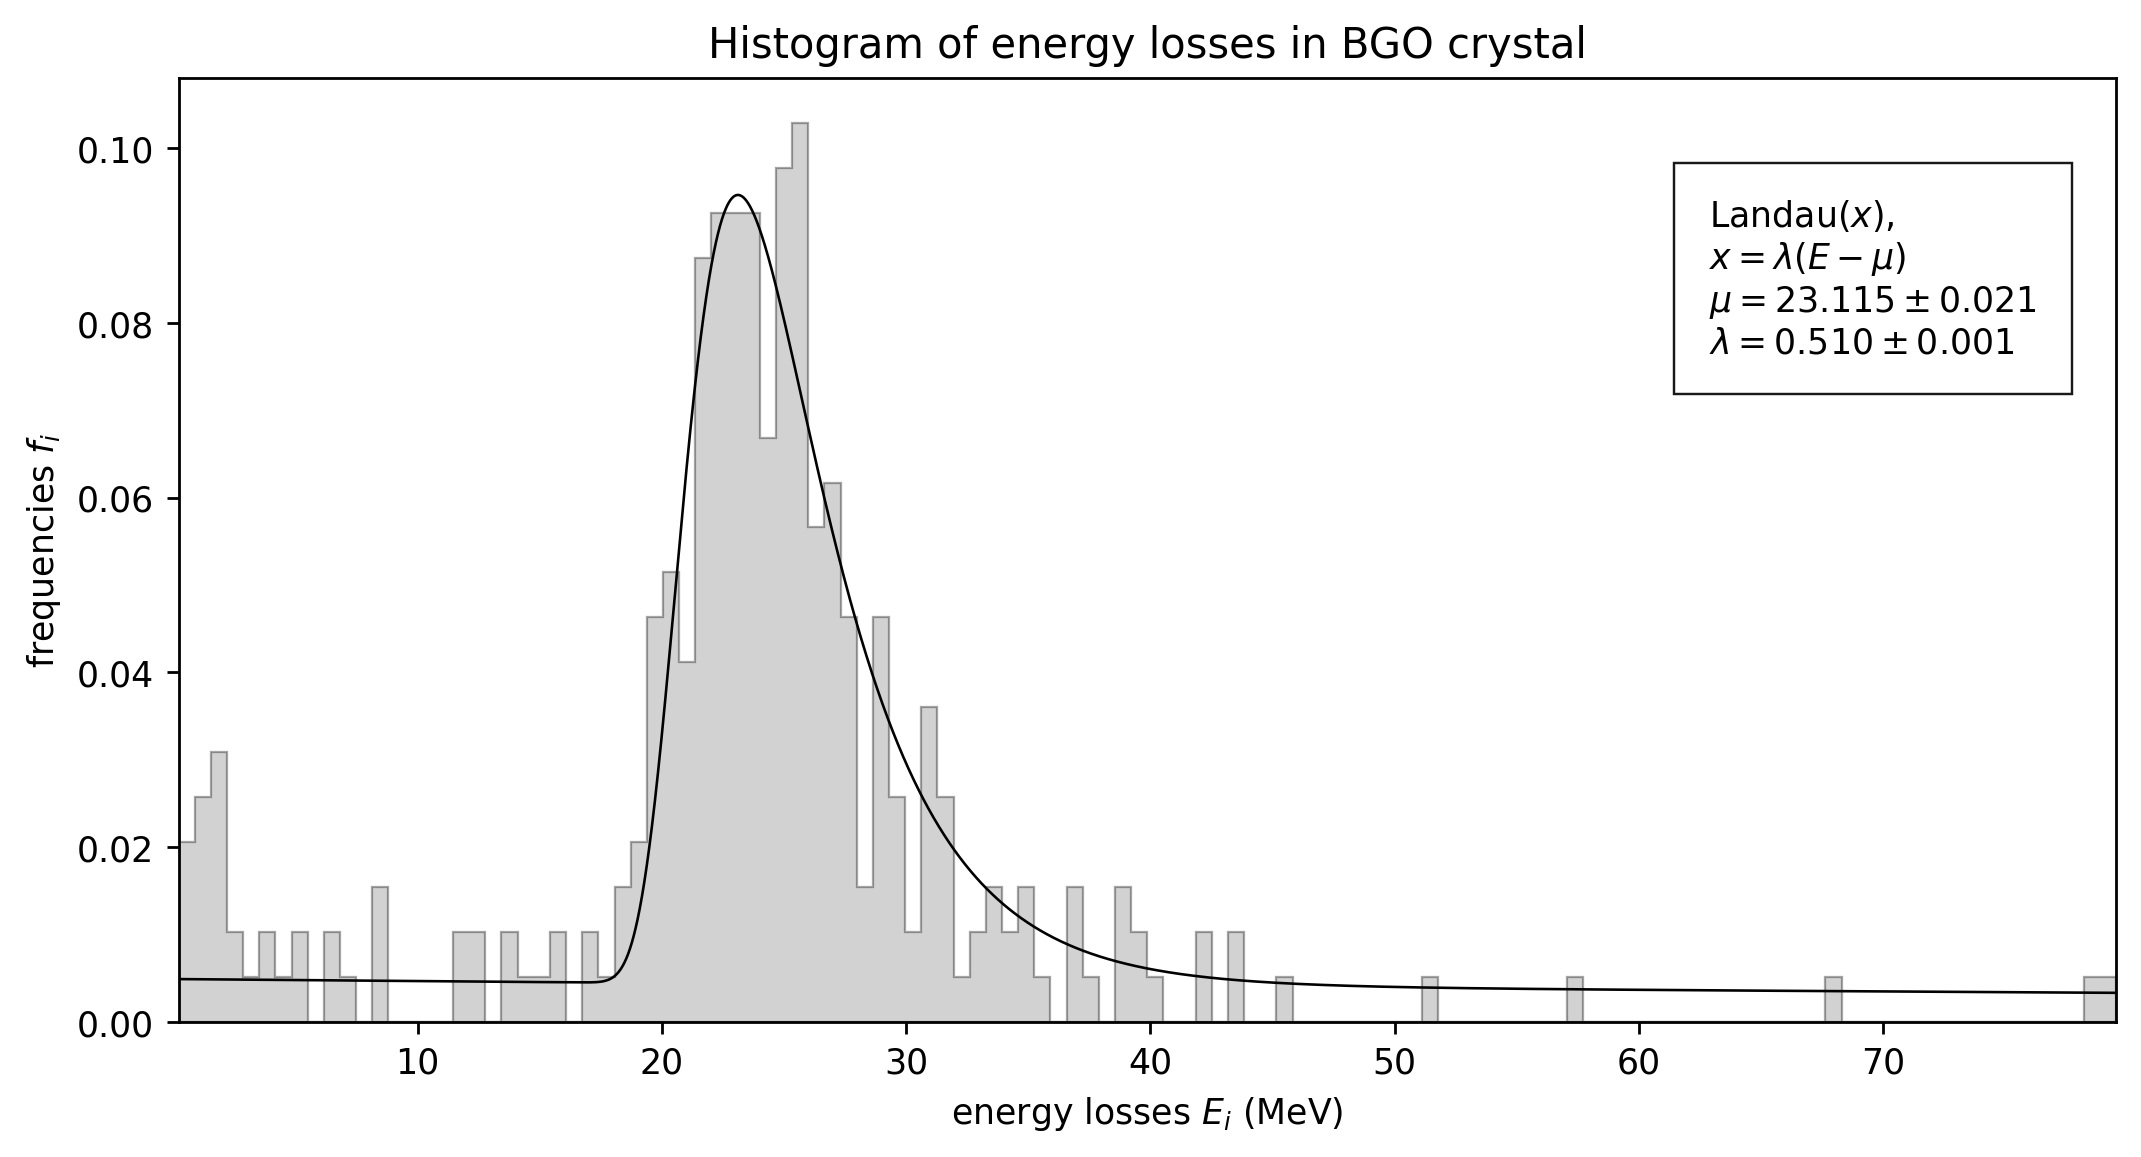

In [6]:
# prepare the figure
fig = plt.figure(111, figsize=(10,5), dpi=250)

# plot the histo
plt.hist(energyBGO, bins=120, label='BGO crystal', histtype="stepfilled",
        color='gray', ec='black', alpha=0.35, lw=0.65, density=True)

# prepare data to plot
energy_samples = np.arange(min(energyBGO), max(energyBGO), 0.0001)
landau_samples = g(energy_samples, mean_energyBGO, form_BGO, normalization_BGO, alphaBGO)

# plot the fitted function
plt.plot(energy_samples, landau_samples, label='Landau distribution', lw=0.75, alpha=2, color="black")

# visualize
plt.title('Histogram of energy losses in BGO crystal')
plt.xlabel('energy losses $E_i$ (MeV)')
plt.xlim(min(energyBGO), max(energyBGO))
plt.ylabel('frequencies $f_i$')
plt.text(min(energyBGO)+0.79*(max(energyBGO)-min(energyBGO)), max(bin_heights)*0.715,
         'Landau$(x)$,\n$x = \lambda(E-\mu)$\n$\mu={0:.3f} \pm {1:.3f}$\n$\lambda = {2:.3f} \pm {3:.3f}$'.format(mean_energyBGO, covariance_BGO[0][0], form_BGO, covariance_BGO[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})
plt.show()
fig.savefig("LandauBGO.jpg",bbox_inches='tight')

### Plastic scintillators
Landau-Vavilov Fit: in this case there are some $\mu^-$ hitting the plastic scintillators in a little region of them (for geometrical reasons). This can be formally included in the analysis via a decreasing exponential function:
$$ f(E) = \alpha e^{-\alpha E} $$
and, as a consequence: $$p(E) = f(E) + Moyal(E)$$

In [7]:
# Moyal distribution + exponential one
def g(x, mean, form, normalization, alpha):
    return normalization*stats.moyal.pdf(form*(x-mean)) + alpha*np.exp(-alpha*x)

Fit:

In [8]:
# extrapolate data from histograms
number_bins = 100
bin_heights_1, bin_borders_1 = np.histogram(energyScint1, bins=number_bins, density=True)
bin_centers_1 = bin_borders_1[:-1] + 0.5*np.diff(bin_borders_1)

bin_heights_2, bin_borders_2 = np.histogram(energyScint2, bins=number_bins, density=True)
bin_centers_2 = bin_borders_2[:-1] + 0.5*np.diff(bin_borders_2)

# fit of the Landau-Moyal function
[mean_energy1, form_1, normalization_1, alpha_1], covariance_1 = optim.curve_fit(g,
    bin_centers_1, bin_heights_1, p0=[18, 0.745, 0.6, 0.06])
[mean_energy2, form_2, normalization_2, alpha_2], covariance_2 = optim.curve_fit(g,
    bin_centers_2, bin_heights_2, p0=[18, 0.745, 0.3, 0.12])

# print results
print("Results of fit on plastic scintillator no. 1:\nmean energy = {0} +/- {1}".format(mean_energy1,covariance_1[0][0]))
print("Form factor = {0} +/- {1}".format(form_1,covariance_1[1][1]))
print("Normalization = {0} +/- {1}".format(normalization_1,covariance_1[2][2]))
print("Alpha = {0} +/- {1}".format(alpha_1,covariance_1[3][3]))
print("\nResults of fit on plastic scintillator no. 2:\nmean energy = {0} +/- {1}".format(mean_energy2,covariance_2[0][0]))
print("Form factor = {0} +/- {1}".format(form_2,covariance_2[1][1]))
print("Normalization = {0} +/- {1}".format(normalization_2,covariance_2[2][2]))
print("Alpha = {0} +/- {1}".format(alpha_2,covariance_2[3][3]))

Results of fit on plastic scintillator no. 1:
mean energy = 18.34311223384437 +/- 0.022930861664949294
Form factor = 1.2071009853452894 +/- 0.026784422224775558
Normalization = 0.3446261647752149 +/- 0.0014344729787252332
Alpha = 0.061768409960436144 +/- 3.176895076596362e-05

Results of fit on plastic scintillator no. 2:
mean energy = 18.425513649850163 +/- 0.025376322966102597
Form factor = 1.400358167074153 +/- 0.05433276192418142
Normalization = 0.35060901600534666 +/- 0.0022176964076946835
Alpha = 0.08899339015626401 +/- 6.058463724429073e-05


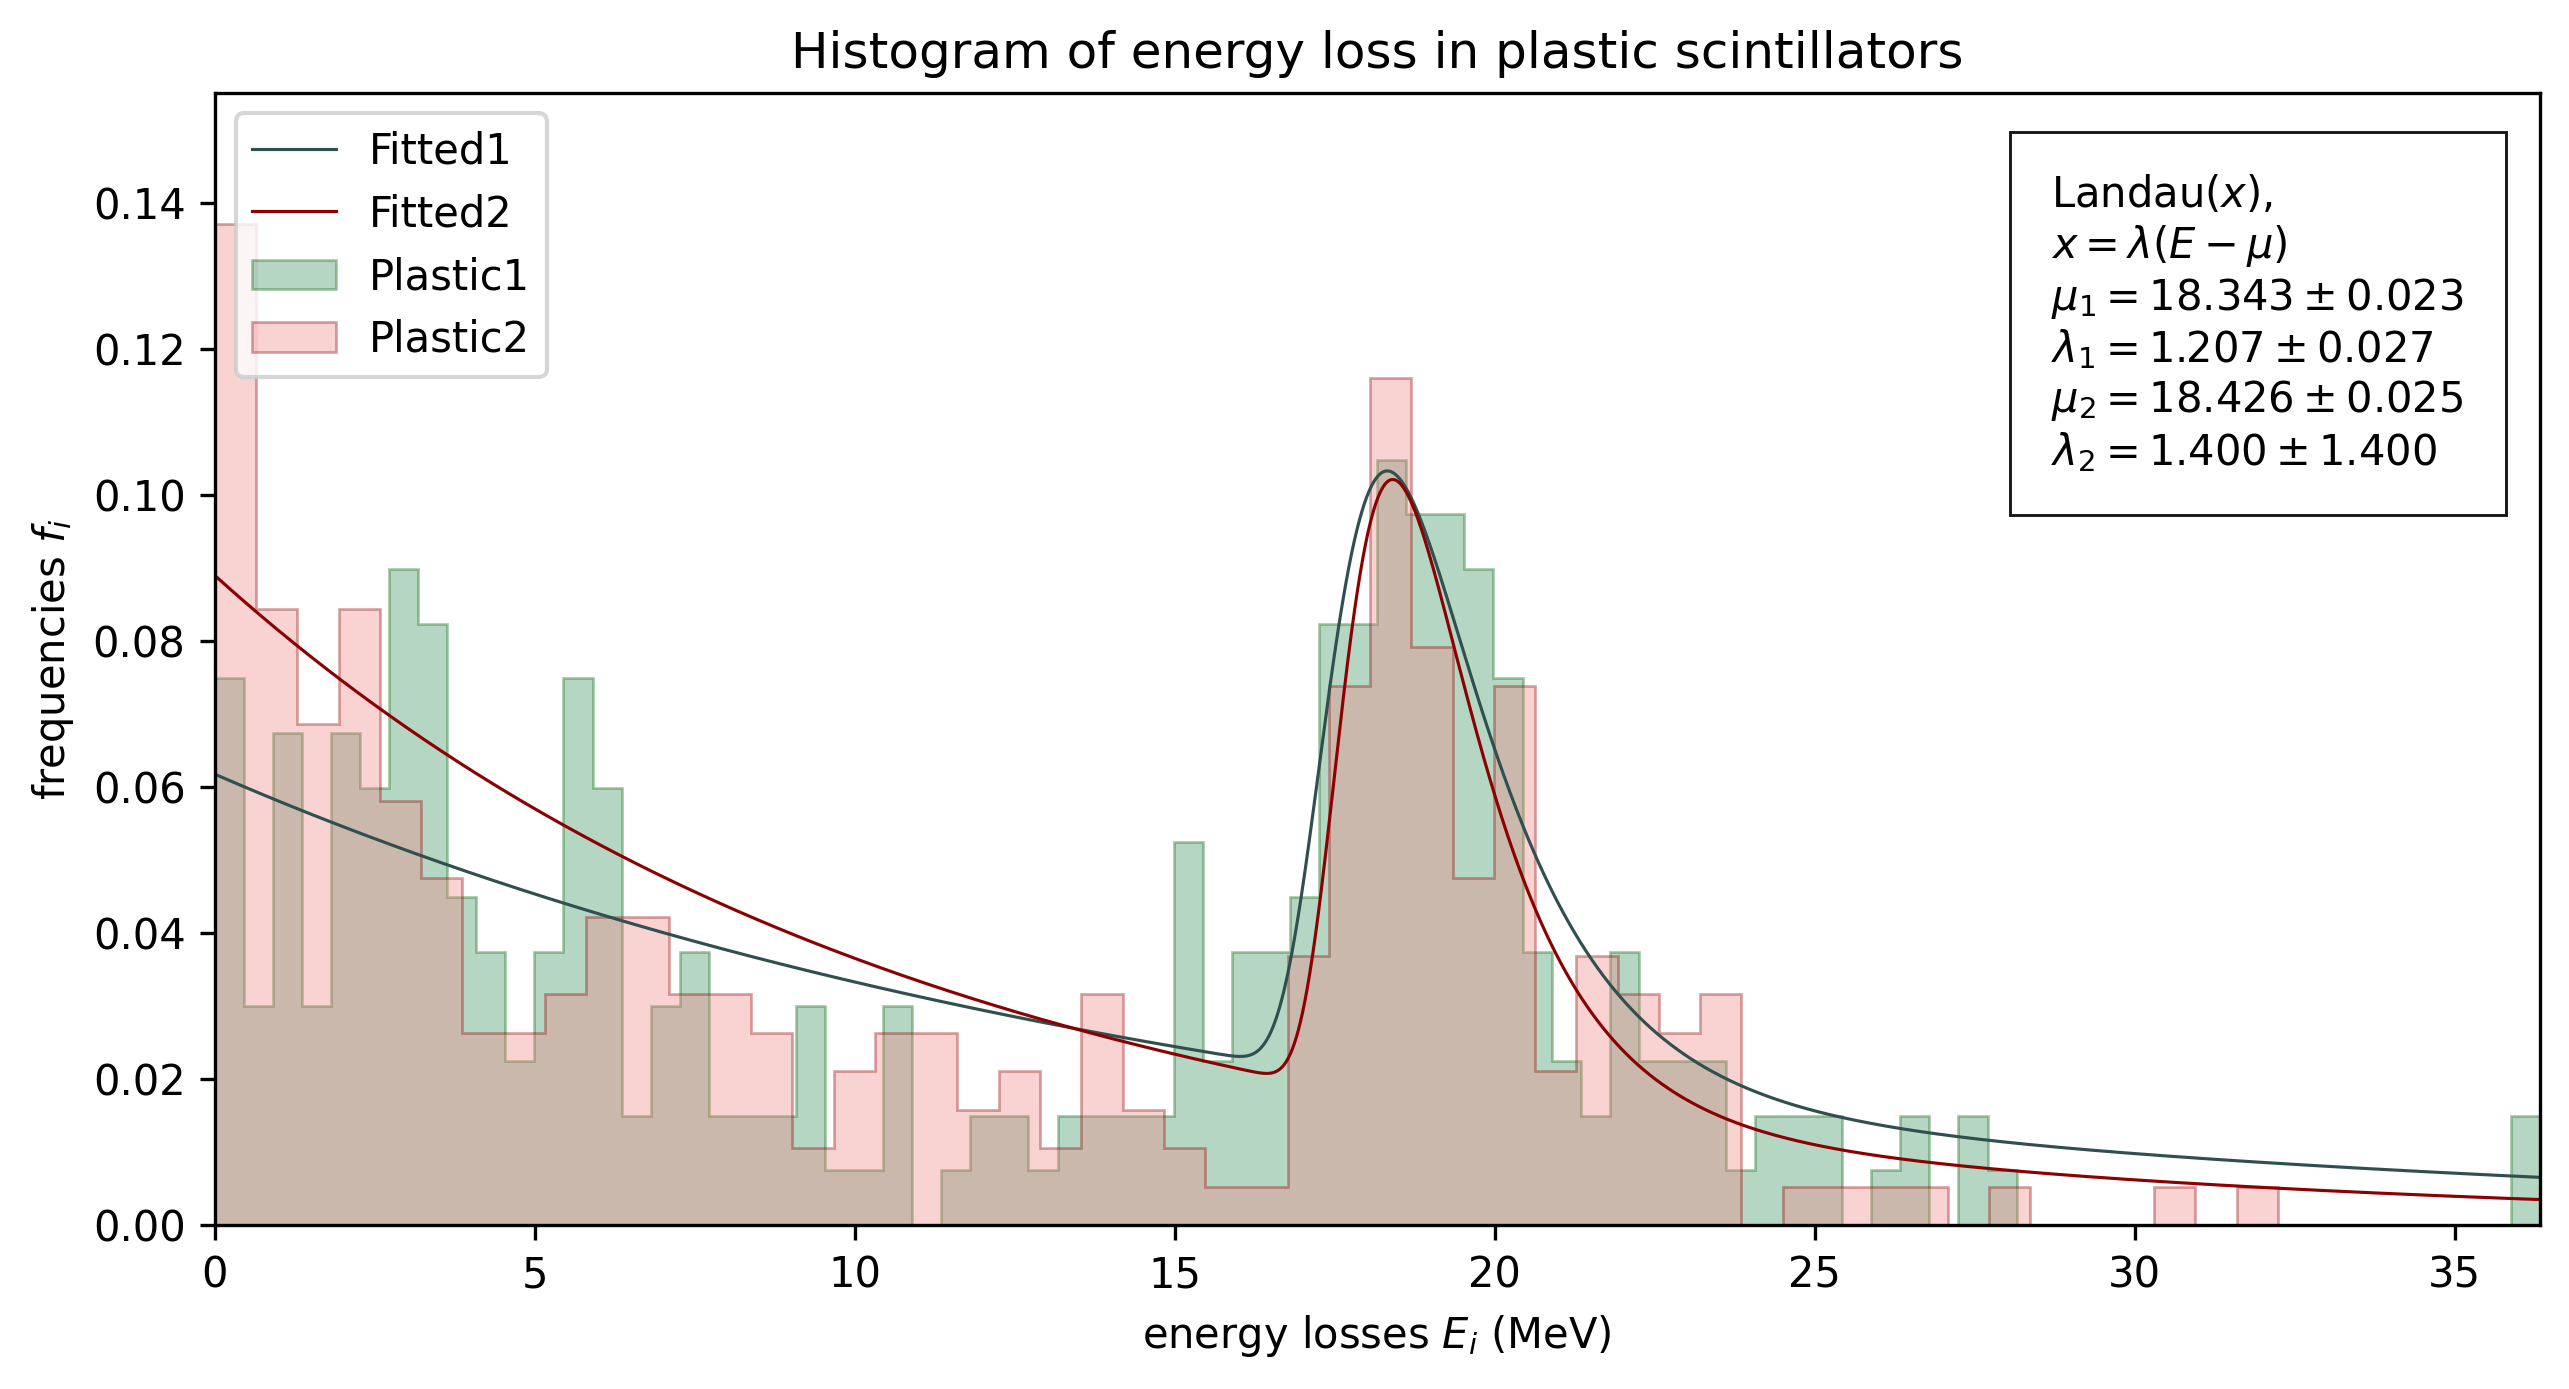

In [9]:
# prepare the figure
fig = plt.figure(111, figsize=(10,5), dpi=300)

# plot the histos
plt.hist(energyScint1, bins=80, label='Plastic1', histtype="stepfilled",
         color="seagreen", ec="darkgreen", alpha=0.35, lw=0.65, density=True)
plt.hist(energyScint2, bins=50, label='Plastic2', histtype="stepfilled",
         color="lightcoral", ec="darkred", alpha=0.35, lw=0.65, density=True)

# prepare data to plot
energy_samples = np.arange( min(min(energyScint1),min(energyScint2)), max(max(energyScint1),max(energyScint2)), 0.0001)
landauExp_samples1 = g(energy_samples, mean_energy1, form_1, normalization_1, alpha_1)
landauExp_samples2 = g(energy_samples, mean_energy2, form_2, normalization_2, alpha_2)

# plot the fitted function
plt.plot(energy_samples, landauExp_samples1, label= 'Fitted1', lw=0.75, alpha=2, color="darkslategrey")
plt.plot(energy_samples, landauExp_samples2, label= 'Fitted2', lw=0.75, alpha=2, color="darkred")

# visualize
plt.title('Histogram of energy loss in plastic scintillators')
plt.xlabel('energy losses $E_i$ (MeV)')
plt.ylabel('frequencies $f_i$')
plt.xlim(0,max(max(energyScint1),max(energyScint2)))
plt.ylim(0,max(max(bin_heights_1),max(bin_heights_2))*1.05)
plt.text(min(energyScint1)+0.79*(max(energyScint1)-min(energyScint1)), max(max(bin_heights_1),max(bin_heights_2))*0.705,
         'Landau$(x)$,\n$x = \lambda(E-\mu)$\n$\mu_1={0:.3f} \pm {1:.3f}$\n$\lambda_1 = {2:.3f} \pm {3:.3f}$\n$\mu_2={4:.3f} \pm {5:.3f}$\n$\lambda_2 = {6:.3f} \pm {6:.3f}$'.format(
             mean_energy1, covariance_1[0][0], form_1, covariance_1[1][1],mean_energy2, covariance_2[0][0], form_2, covariance_2[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})
plt.legend(loc='upper left')
plt.show()
fig.savefig("LandauPlastics.jpg",bbox_inches='tight')

## <span style="color:lightskyblue">Cherenkov</span> vs. <span style="color:khaki">scintillation</span> data analysis

Loading data from `energies.txt`:

In [10]:
# loading data from simulation
set1, set2 = np.loadtxt(fileName, unpack=True, usecols=(4,5))
energyCherenkov = []
energyScintillation = []
energies = [energyCherenkov, energyScintillation]

# remove energies = 0 and energies > 200 MeV from datasets
for value in set1:
    if value > 0 and value < 200:
        # Cherenkov light: from MeV to keV
        energyCherenkov.append(value*1000)

for value in set2:
    if value > 0 and value < 200:
        energyScintillation.append(value*1000)

# number of Monte Carlo events
numberofevents = len(energyCherenkov)
print("You have {0} data".format(numberofevents))

You have 294 data


##### Landau-Vavilov Fit + exponential decay:
A good limit of the Landau distribution is the Moyal pdf:
$$ p(x) = \frac{1}{\sqrt{2\pi}} \exp \left( -\frac{x-e^{-x}}{2} \right) $$
For geometrical reasons, there are some $\mu^-$ hitting the crystal scintillators in a little region of it. This can be formally included in the analysis via a decreasing exponential function:
$$ f(E) = \alpha e^{-\alpha E} $$
and, as a consequence: $$p(E) = f(E) + Moyal(E)$$

In [11]:
# Moyal distribution + parameters
def f(x,mean,form,normalization):
    return normalization*stats.moyal.pdf(form*(x-mean))

# Moyal distribution + exponential one
def g(x, mean, form, normalization, alpha):
    return normalization*stats.moyal.pdf(form*(x-mean)) + alpha*np.exp(-alpha*x)

#### Fit of both Cherenkov and Scintillation distributions:

In [12]:
# CHERENKOV LIGHT FIT
# extrapolate data from histogram
nbins_c=80
bin_heightsCherenkov, bin_bordersCherenkov = np.histogram(energyCherenkov, bins=nbins_c, density=True)
bin_centersCherenkov = bin_bordersCherenkov[:-1] + 0.5*np.diff(bin_bordersCherenkov)
# fit of the Landau-Moyal function
#[mean_energyCherenkov, form_Cherenkov, normalization_Cherenkov, alphaCherenkov], covariance_Cherenkov = optim.curve_fit(g, bin_centersCherenkov, bin_heightsCherenkov, p0=[np.mean(energyCherenkov),4,1,bin_heightsCherenkov[0]])
[mean_energyCherenkov, form_Cherenkov, normalization_Cherenkov], covariance_Cherenkov = optim.curve_fit(f, bin_centersCherenkov, bin_heightsCherenkov, p0=[np.mean(energyCherenkov), 10, max(bin_heightsCherenkov)])

#SCINTILLATION LIGHT FIT
bin_heightsScintillation, bin_bordersScintillation = np.histogram(energyScintillation, bins=nbins_c, density=True)
bin_centersScintillation = bin_bordersScintillation[:-1] + 0.5*np.diff(bin_bordersScintillation)

[mean_energyScintillation, form_Scintillation, normalization_Scintillation], covariance_Scintillation = optim.curve_fit(f, bin_centersScintillation, bin_heightsScintillation, p0=[np.mean(energyScintillation), 0.10, max(bin_heightsScintillation)])

# print results
print('CHERENKOV:')
print("Results of fit:\nmean energy = {0} +/- {1}".format(mean_energyCherenkov,covariance_Cherenkov[0][0]))
print("Form factor = {0} +/- {1}".format(form_Cherenkov,covariance_Cherenkov[1][1]))
print("Normalization = {0} +/- {1}".format(normalization_Cherenkov,covariance_Cherenkov[2][2]))
#print("Alpha = {0} +/- {1}".format(alphaCherenkov,covariance_Cherenkov[3][3]))
print('\nSCINTILLATION:')
print("Results of fit:\nmean energy = {0} +/- {1}".format(mean_energyScintillation,covariance_Scintillation[0][0]))
print("Form factor = {0} +/- {1}".format(form_Scintillation,covariance_Scintillation[1][1]))
print("Normalization = {0} +/- {1}".format(normalization_Scintillation,covariance_Scintillation[2][2]))
#print("Alpha = {0} +/- {1}".format(alphaScintillation,covariance_Scintillation[3][3]))

CHERENKOV:
Results of fit:
mean energy = 0.3622836207939902 +/- 0.0002634248513967471
Form factor = 6.007321596801905 +/- 0.19180655706044453
Normalization = 5.859748799683916 +/- 0.11881112909684681

SCINTILLATION:
Results of fit:
mean energy = 37.10977801963044 +/- 0.6796912438748174
Form factor = 0.1150385976904034 +/- 6.527040997668693e-05
Normalization = 0.0988656223339073 +/- 3.1875692195563674e-05


Plot:

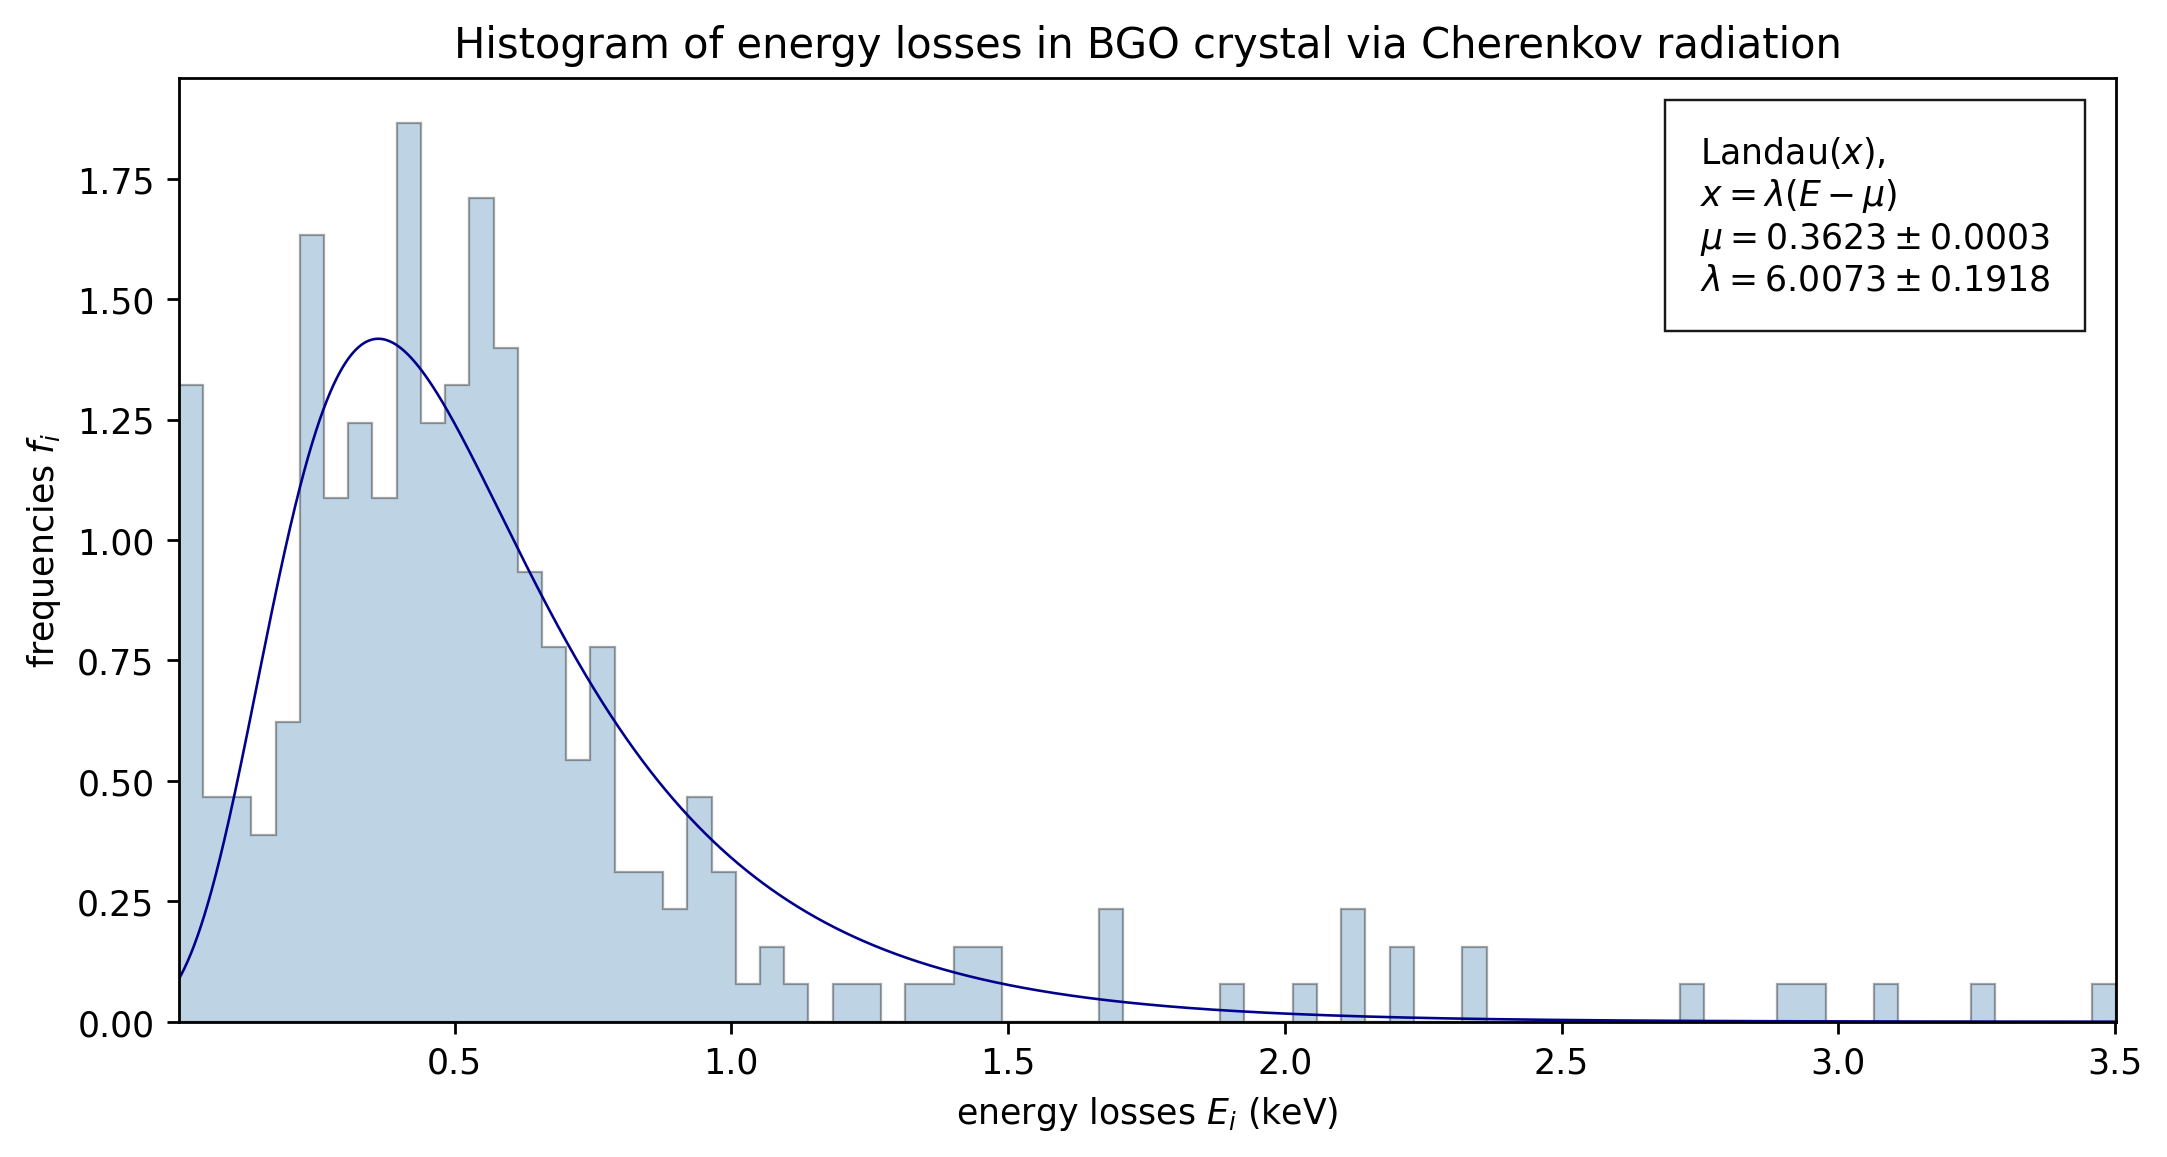

In [13]:
# prepare the figure
fig = plt.figure(111, figsize=(10,5), dpi=250)

# plot the histo
plt.hist(energyCherenkov, bins=nbins_c, label='BGO crystal', histtype="stepfilled",
        color='steelblue', ec='black', alpha=0.35, lw=0.65, density=True)

# prepare data to plot
energy_samples = np.arange(min(energyCherenkov), max(energyCherenkov), 0.0001)
#landau_samples = g(energy_samples, mean_energyCherenkov, form_Cherenkov, normalization_Cherenkov, alphaCherenkov)
landau_samples = f(energy_samples, mean_energyCherenkov, form_Cherenkov, normalization_Cherenkov)

# plot the fitted function
plt.plot(energy_samples, landau_samples, label='Landau distribution', lw=0.75, alpha=2, color="darkblue")

# visualize
plt.title('Histogram of energy losses in BGO crystal via Cherenkov radiation')
plt.xlabel('energy losses $E_i$ (keV)')
plt.xlim(min(energyCherenkov), max(energyCherenkov))
plt.ylabel('frequencies $f_i$')
plt.text(min(energyCherenkov)+0.785*(max(energyCherenkov)-min(energyCherenkov)), max(bin_heightsCherenkov)*0.815,
         'Landau$(x)$,\n$x = \lambda(E-\mu)$\n$\mu={0:.4f} \pm {1:.4f}$\n$\lambda = {2:.4f} \pm {3:.4f}$'.format(mean_energyCherenkov, covariance_Cherenkov[0][0], form_Cherenkov, covariance_Cherenkov[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})
plt.show()
fig.savefig("LandauCerenkov.jpg", bbox_inches='tight')

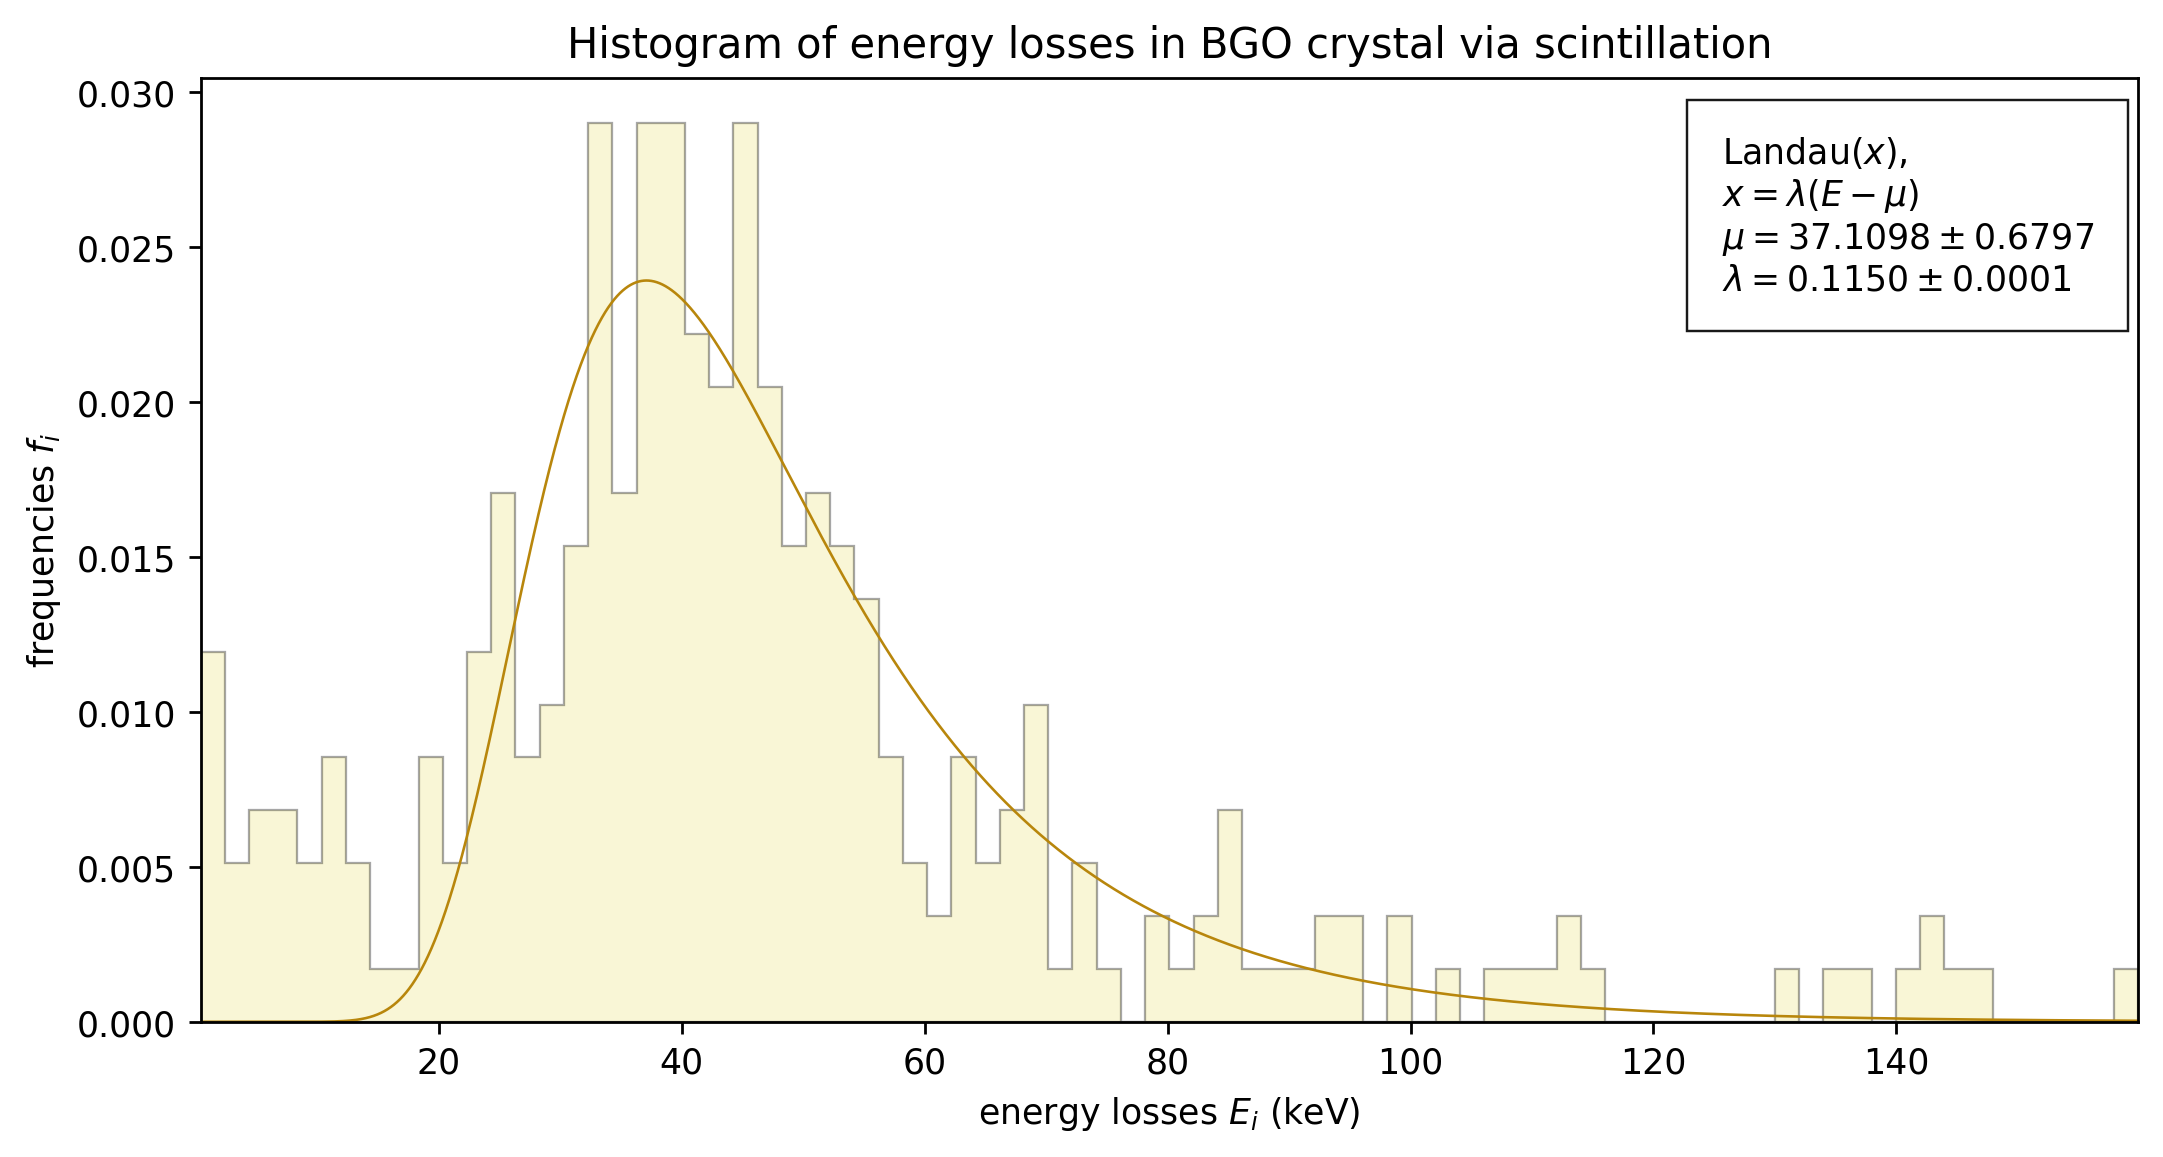

In [14]:
# prepare the figure
fig = plt.figure(111, figsize=(10,5), dpi=250)

# plot the histo
plt.hist(energyScintillation, bins=nbins_c, label='BGO crystal', histtype="stepfilled",
        color='khaki', ec='black', alpha=0.35, lw=0.65, density=True)

# prepare data to plot
energy_samplesS = np.arange(min(energyScintillation), max(energyScintillation), 0.0001)
#landau_samplesS = g(energy_samples, mean_energyScintillation, form_Scintillation, normalization_Scintillation, alphaScintillation)
landau_samplesS = f(energy_samplesS, mean_energyScintillation, form_Scintillation, normalization_Scintillation)

# plot the fitted function
plt.plot(energy_samplesS, landau_samplesS, label='Landau distribution', lw=0.75, alpha=2, color="darkgoldenrod")

# visualize
plt.title('Histogram of energy losses in BGO crystal via scintillation')
plt.xlabel('energy losses $E_i$ (keV)')
plt.xlim(min(energyScintillation), max(energyScintillation))
plt.ylabel('frequencies $f_i$')
plt.text(min(energyScintillation)+0.785*(max(energyScintillation)-min(energyScintillation)), max(bin_heightsScintillation)*0.815,
         'Landau$(x)$,\n$x = \lambda(E-\mu)$\n$\mu={0:.4f} \pm {1:.4f}$\n$\lambda = {2:.4f} \pm {3:.4f}$'.format(mean_energyScintillation, covariance_Scintillation[0][0], form_Scintillation, covariance_Scintillation[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})
plt.show()
fig.savefig("LandauScintillation.jpg", bbox_inches='tight')

## Cerenkov vs scintillation ratio

In [15]:
numberCherenkov, numberScintillation = np.loadtxt(fileName, unpack=True, usecols=(6,7))

nCerenkov = sum(numberCherenkov)
nScintillation = sum(numberScintillation)

print(r'C/S ratio for counting = {:e}'.format(nCerenkov/nScintillation))
print(r'C/S ratio for energies = {:e}'.format(sum(energyCherenkov)/sum(energyScintillation)))

C/S ratio for counting = 1.234781e-02
C/S ratio for energies = 1.288563e-02
